In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from google.colab import drive
from torch.utils.data import Dataset
drive.mount('/content/drive')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


In [ ]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.1307,), std = (0.3081,))
    ]
)

In [ ]:
bs = 100
# own Dataset
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.path = "/content/drive/MyDrive/"
        self.name = '/porous.npz'
        self.files = self.path + self.name
        xy = np.load(str(self.files))
        force = xy["img_all"]
        label = xy["label"]
        image = torch.as_tensor(force)
        image = image.to(torch.float32)
        self.images = image.view(-1, 1, 64, 64)
        self.labels = torch.as_tensor(label)
        self.transform = transform

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        #image = self.transform(np.array(image))
        return image, label
    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(transform=data_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = train_dataloader


In [ ]:
def plot_examples(images, labels, rows=1):   #by default set rows=1
    fig = plt.figure()
    columns = len(images) // (rows)
    for i, (img, lab) in enumerate(zip(images, labels)):
        print(img)
        if i < columns*rows:
            ax = fig.add_subplot(rows, columns, i+1)
            ax.imshow(img.reshape(64, 64),cmap="gray")
            ax.set_xticks([]) #set empty label for x axis
            ax.set_yticks([]) #set empty label for y axis
            ax.set_title("label: {}".format(lab.item()))
    plt.tight_layout()
    return fig

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.9961, 0.9727, 0.3125,  ..., 0.0078, 0.0000, 0.0000],
         [0.2852, 0.2734, 0.1797,  ..., 0.0117, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]]])
tensor([[[0.3047, 0.6914, 0.2031,  ..., 0.2891, 0.3945, 0.0977],
         [0.3320, 0.5078, 0.7305,  ..., 0.2422, 0.5039, 0.5000],
         [0.1758, 0.2227, 0.4727,  ..., 0.3281, 0.5898, 0.1094],
         ...,
         [0.4023, 0.1133, 0.6992,  ..., 0.2109, 0.3398, 0.0508],
         [0.2812, 0.3164, 0.5938,  ..., 0.8047, 0.2891, 0.1016],
         [0.0078, 0.3242, 0.1172,  ..., 0.2305, 0.0469, 0.0664]]])
tensor([[[0.3672, 0.1289, 0.0078,  ..., 0.0703, 0.0156, 0.0195],
         [0.2109, 0.2656, 0.0039,  ..., 0.4961, 0.3398, 0.0078],
         [0.0625, 0.4414, 0.2852,  ..., 0.1797, 0.0273, 0.

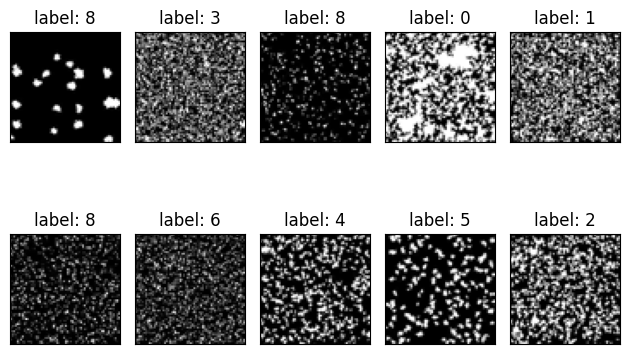

In [ ]:
examples = enumerate(train_dataloader)
batch_idx, (images, labels) = next(examples)
images_=images[0:10]
labels_=labels[0:10]
plot_examples(images_, labels_, rows=2);

In [ ]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super(CVAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample

    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 64*64), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

# build model
cond_dim = 10
cvae = CVAE(x_dim=64*64, h_dim1=512, h_dim2=256, z_dim=2, c_dim=cond_dim)
if torch.cuda.is_available():
    cvae.cuda()

In [ ]:
cvae

CVAE(
  (fc1): Linear(in_features=4106, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=20, bias=True)
  (fc32): Linear(in_features=256, out_features=20, bias=True)
  (fc4): Linear(in_features=30, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=4096, bias=True)
)

In [ ]:
optimizer = optim.Adam(cvae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    Diff_loss = F.binary_cross_entropy(recon_x, x.view(-1, 64*64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return Diff_loss + KLD

# one-hot encoding
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [ ]:
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, cond) in enumerate(train_dataloader):
        data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                10. * batch_idx / len(train_dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

In [ ]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, cond in test_loader:
            data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
            recon, mu, log_var = cvae(data, cond)
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# train
for epoch in range(1, 1001):
    train(epoch)
    test()

Train Epoch: 1 [0/1076 (0%)]	Loss: 2844.496250
====> Epoch: 1 Average loss: 2671.8670
====> Test set loss: 2495.1989
Train Epoch: 2 [0/1076 (0%)]	Loss: 2538.490625
====> Epoch: 2 Average loss: 2396.9226
====> Test set loss: 2308.1732
Train Epoch: 3 [0/1076 (0%)]	Loss: 2225.611406
====> Epoch: 3 Average loss: 2286.5949
====> Test set loss: 2279.5754
Train Epoch: 4 [0/1076 (0%)]	Loss: 2344.526563
====> Epoch: 4 Average loss: 2278.2042
====> Test set loss: 2266.5846
Train Epoch: 5 [0/1076 (0%)]	Loss: 2248.580313
====> Epoch: 5 Average loss: 2265.2368
====> Test set loss: 2259.4495
Train Epoch: 6 [0/1076 (0%)]	Loss: 2241.062812
====> Epoch: 6 Average loss: 2258.9167
====> Test set loss: 2253.8431
Train Epoch: 7 [0/1076 (0%)]	Loss: 2222.529844
====> Epoch: 7 Average loss: 2252.1129
====> Test set loss: 2247.4453
Train Epoch: 8 [0/1076 (0%)]	Loss: 2255.398750
====> Epoch: 8 Average loss: 2244.7097
====> Test set loss: 2236.7685
Train Epoch: 9 [0/1076 (0%)]	Loss: 2254.302813
====> Epoch: 9 Av

In [ ]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,10).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(64, 64), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

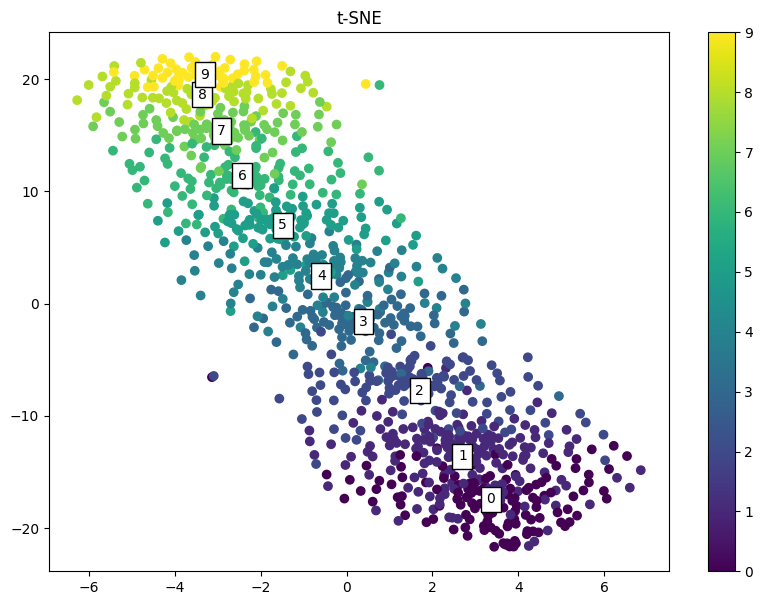

In [ ]:

plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)


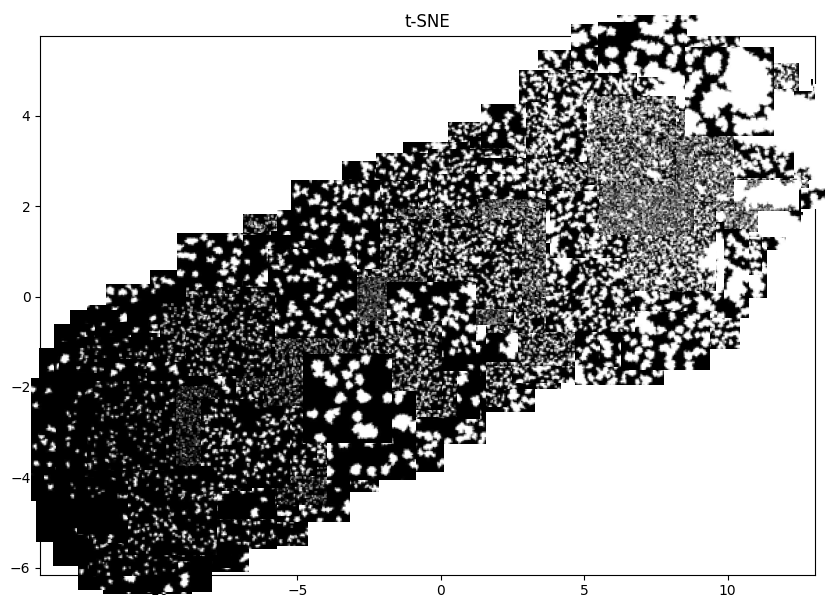

In [ ]:
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)


In [ ]:

with torch.no_grad():
    z = torch.randn(10, 2).cuda()
    c = torch.eye(10).cuda()

    sample = cvae.decoder(z, c)
    #save_image(sample.view(10, 1, 28, 28), './samples/sample_' + '.png')
    save_image(sample.view(10, 1, 64, 64), '/content/drive/MyDrive/samples/sample4_' + '.png')